In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pickle
import scipy.stats as stats
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from functools import partial
from scipy.stats import linregress
from imblearn.over_sampling import SMOTE
from torch import nn
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam, Adagrad
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
import xgboost

/tmp/ipykernel_290769/2861718709.py:6: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
train_df_original = pd.read_pickle("all_df.pkl")
test_df_original = pd.read_pickle("all_df_test.pkl")

In [16]:
def run_and_eval(model_class, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    X_test_copy = X_test.copy()
    X_test_copy['preds'] = y_pred
    evaluate_model(y_true=y_test, y_pred=y_pred)
    return y_pred

In [5]:
def evaluate_model(y_true,y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)
    precision = precision_score(y_true, y_pred)
    print("Precision:", precision)
    recall = recall_score(y_true, y_pred)
    print("Recall:", recall)
    f1 = f1_score(y_true, y_pred)
    print("F1 Score:", f1)
    auc = roc_auc_score(y_true, y_pred)
    print("AUC-ROC:", auc)
    mae = mean_absolute_error(y_true, y_pred)
    print("Mean Absolute Error:", mae)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("Root Mean Squared Error:", rmse)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

In [6]:
def outliers_perc_of_col(target, df):
    df_not_null = df[target].dropna()
    Q1 = np.percentile(df_not_null, 25)
    Q3 = np.percentile(df_not_null, 75)
    IQR = Q3 - Q1
    ul = Q3 + 1.5 * IQR
    ll = Q1 - 1.5 * IQR
    outliers = df_not_null[(df_not_null > ul) | (df_not_null < ll)]
    outliers_per = round((len(outliers)/len(df_not_null))*100,2)
    return outliers_per

# EDA 

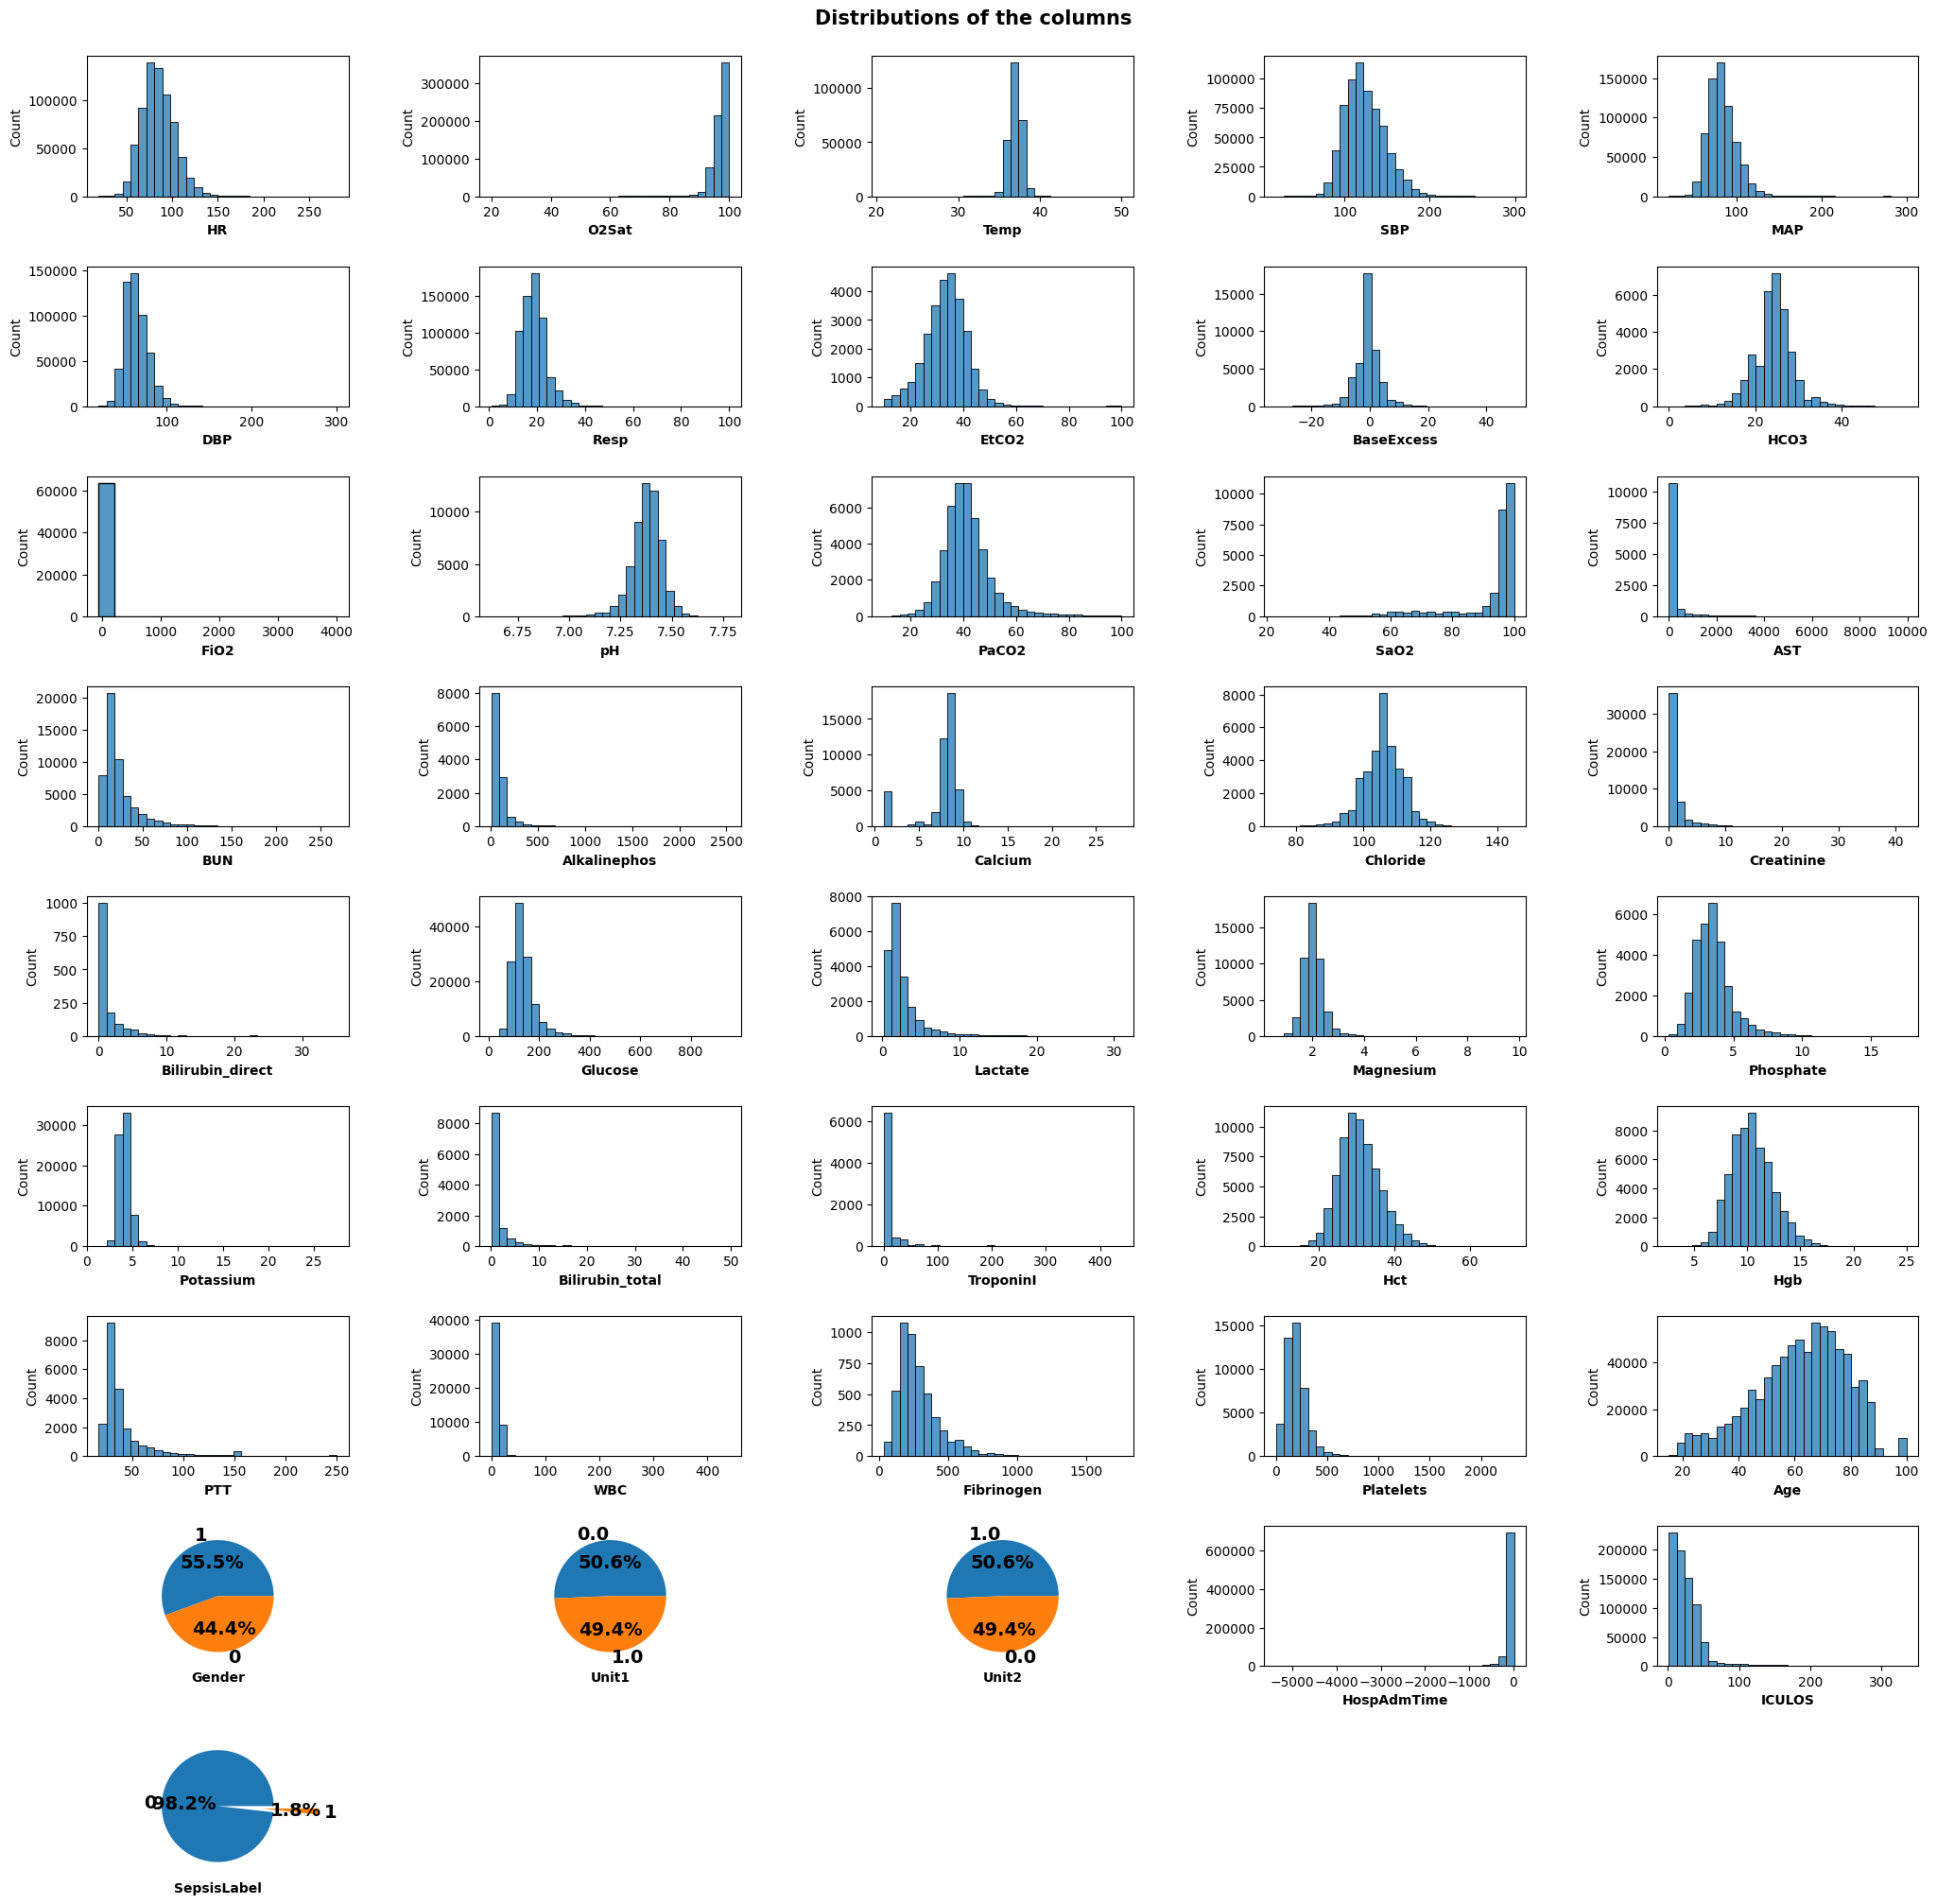

In [11]:
df = train_df_original
columns = df.columns.tolist()
fig, axes = plt.subplots(nrows=9, ncols=5, figsize=(25, 25))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Distributions of the columns", fontsize=15, fontweight="bold", y=0.9)

i = 0
for col in df.columns:
    if col != "patient id":
        if df[col].nunique() == 2:
            if col != 'SepsisLabel':
                counts = df.groupby('patient id')[col].mean().value_counts()
            else:
                counts = df[col].value_counts()
            if counts[1]/(counts[0]+counts[1]) > 0.95 or counts[1]/(counts[0]+counts[1]) < 0.05:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%', explode=(0, 0.8), textprops={'fontsize': 14, 'weight':'bold'})
            else:
                axes[i//5, i%5].pie(counts, labels=counts.index, autopct='%1.1f%%', textprops={'fontsize': 14, 'weight':'bold'})
        else:
            if col == "FiO2":
                sns.histplot(df[col], ax=axes[i//5, i%5], bins=15)
            else:
                sns.histplot(df[col], ax=axes[i//5, i%5], bins=30)
                
        axes[i//5, i%5].set_xlabel(col, fontweight="bold")
        axes[i//5, i%5].grid(False)
        i += 1
        
fig.delaxes(axes[8,1])
fig.delaxes(axes[8,2])
fig.delaxes(axes[8,3])
fig.delaxes(axes[8,4])
plt.show()

Bilirubin_direct    99.810662
Fibrinogen          99.357921
TroponinI           99.031666
Bilirubin_total     98.528852
Alkalinephos        98.420491
AST                 98.403670
Lactate             97.321107
PTT                 97.092650
SaO2                96.499862
EtCO2               96.421753
Phosphate           96.028213
HCO3                95.852176
Chloride            95.490713
BaseExcess          94.513381
PaCO2               94.392242
Calcium             94.142921
Platelets           94.073419
Creatinine          93.923071
Magnesium           93.711304
WBC                 93.602813
BUN                 93.149290
pH                  92.990596
Hgb                 92.602401
FiO2                91.681010
Hct                 91.116257
Potassium           90.659996
Glucose             82.824912
Temp                66.077269
Unit1               39.010072
Unit2               39.010072
DBP                 31.189463
Resp                15.431408
SBP                 14.713047
O2Sat     

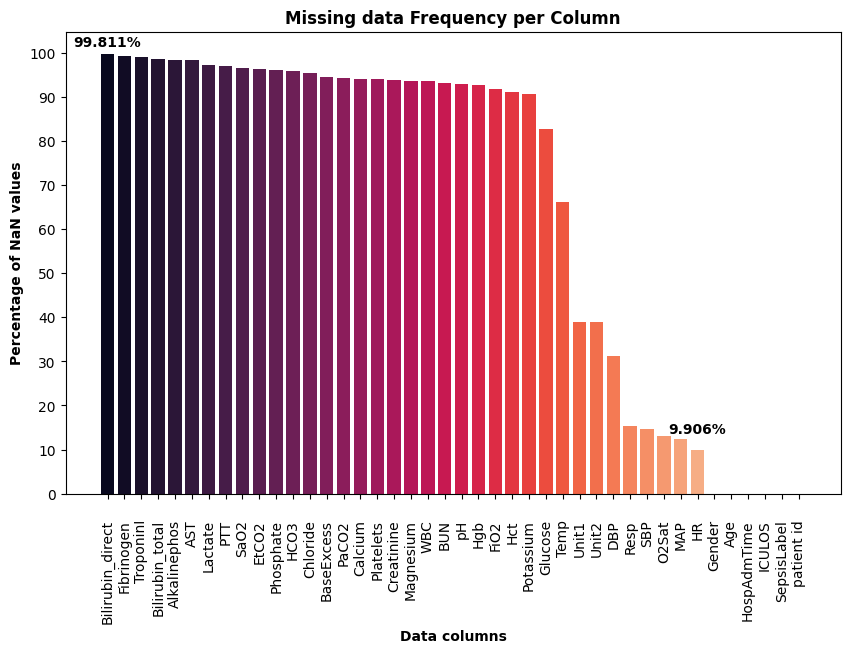

In [12]:
nan_counts = df.isnull().sum().sort_values(ascending=False)
nan_perc = nan_counts / len(df) * 100
print(nan_perc)
# Define color palette
colors = sns.color_palette("rocket", len(nan_counts))

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(nan_counts.index, nan_perc.values, color=colors)
ax.set_xticks(range(len(nan_counts)))
ax.set_xticklabels(nan_counts.index, rotation=90, ha='center', fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
ax.set_ylabel('Percentage of NaN values', fontweight = "bold")
ax.set_xlabel('Data columns', fontweight = "bold")
ax.set_title('Missing data Frequency per Column', fontweight = "bold")
y_ticks = np.arange(0, 101, 10)
ax.set_yticks(y_ticks)
plt.grid(False)

# Add text labels to highest and lowest non-zero bars
non_zero_perc = nan_perc[nan_perc > 0]
if len(non_zero_perc) > 0:
    max_idx = non_zero_perc.idxmax()
    min_idx = non_zero_perc.idxmin()
    ax.text(max_idx, non_zero_perc[max_idx]+1, f'{non_zero_perc[max_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')
    ax.text(min_idx, non_zero_perc[min_idx]+3, f'{non_zero_perc[min_idx]:.3f}%', ha='center', va='bottom', fontweight='bold')

plt.show()

# Pre-Processing

In [13]:
def pre_process(df, type_df="train"):
    patients_size = df.groupby("patient id").size()
    patients_size = patients_size[patients_size >= 36]
    full_hours_df = df[df['patient id'].isin(patients_size.index)].reset_index(drop=True)
    
    # backward and forward fill 
    df_processed = df.groupby('patient id').apply(lambda x: x.bfill().ffill()).reset_index(drop=True)
    outlier_perc_dict = {}
    # Filling the rest of null values based on median/mean/mode according to the feature's outliers
    for col in df_processed.columns:
        outlier_perc_dict[col] = [outliers_perc_of_col(col, df_processed)]
    outliers_perc_df = pd.DataFrame(outlier_perc_dict).T
    outliers_perc_df.columns = ["Outliers %"]
    outliers_perc_df = outliers_perc_df.sort_values(by=['Outliers %'], ascending=False)
    columns = df_processed.columns
    for col in columns:
        median = full_hours_df[col].median()
        df_processed[col] = df_processed[col].fillna(median)
        avg =full_hours_df[col].mean()
        mode = full_hours_df[col].mode()[0]
        outlier_perc = outliers_perc_df.loc[col,'Outliers %']
        if df_processed[col].nunique() == 2:
            df_processed[col] = df_processed[col].fillna(mode)
        else:
            if outlier_perc <= 5:
                df_processed[col] = df_processed[col].fillna(avg)
            elif outlier_perc > 5:
                df_processed[col] = df_processed[col].fillna(median)
    
    # data transformations 
    condition_temp=(df_processed['Temp'] > 38) | ( df_processed['Temp'] < 36)
    condition_HR=(df_processed['HR'] > 90)
    condition_Resp=(df_processed['Resp'] > 20) | ( df_processed['PaCO2'] < 32)
    condition_wbc=(df_processed['WBC']*10**3 > 12000) | (df_processed['WBC']*10**3 < 4000)
    df_processed['SIRS'] = np.where(condition_temp, 1, 0)+np.where(condition_HR, 1, 0)+np.where(condition_Resp, 1, 0)+np.where(condition_wbc, 1, 0)
    df_processed['SIRS'] = np.where(df_processed['SIRS'] >= 2, 1, 0)
    
    df_processed["BUN_Creatinine_ratio"] = df_processed["BUN"]/df_processed["Creatinine"]
    df_processed["qSOFA"] = np.where((df_processed['SBP'] >= 100) & (df_processed['Resp'] >= 22), 1, 0)
    
    # Feature selection
    cols = ["ICULOS", "Lactate", "Temp", "SIRS", "PaCO2", "Unit1", "FiO2", "AST", "pH", "Hgb", "WBC", "BUN", "Calcium", "BaseExcess",
        "HospAdmTime", "patient id", "Hct", "HCO3", "HR", "MAP", "SaO2", "Alkalinephos", "Magnesium", "Potassium", 
        "Bilirubin_total", "Phosphate", "O2Sat", "BUN_Creatinine_ratio", "PTT", "SBP", "SepsisLabel"]
    df_processed = df_processed[cols]
    
    # Aggregations - remain only one record for each patient 
    groups = df_processed.groupby('patient id')
    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=df_processed.columns)#
    # Loop through the groups
    for name, group in groups:
        # Check if there is at least one row with label 1
        if (group['SepsisLabel'] == 1).any():
            # If there is, select the first row with label 1
            row = group[group['SepsisLabel'] == 1].iloc[0]
        else:
            # If there is no row with label 1, select the last row
            row = group.iloc[-1]
        
        # Add the selected row to the results DataFrame
        results.loc[name] = row

    # undersampling
    if type_df == "train":
        majority_class = results[results['SepsisLabel'] == 0]
        minority_class = results[results['SepsisLabel'] == 1]
        majority_subset = majority_class.sample(n=5*len(minority_class), random_state=1000)
        results = results[(results['SepsisLabel'] == 1) | ((results['SepsisLabel'] == 0) & (results.index.isin(majority_subset.index)))].reset_index(drop=True)

    X = results.drop(['SepsisLabel','patient id'], axis=1)
    y = results['SepsisLabel']
    
    return X, y, results

In [14]:
X_train, y_train, train_df = pre_process(train_df_original, type_df = "train")
X_test, y_test, test_df = pre_process(test_df_original, type_df = "test")

# Feature importance 

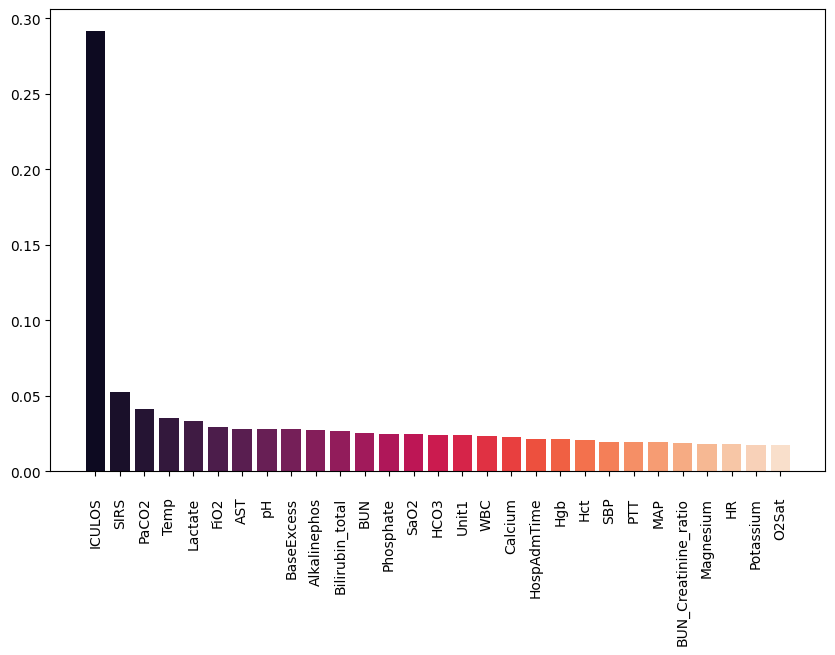

In [15]:
model = XGBClassifier(n_estimators=200, max_depth=50, eta=0.05, gamma=0.1, reg_lambda=0.8, min_child_weight=2)
model.fit(X_train, y_train)

importances_df = pd.DataFrame({"feature_names" : model.feature_names_in_, "importances" : model.feature_importances_}).sort_values(by='importances', ascending=False)
colors = sns.color_palette("rocket", len(model.feature_names_in_))

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(importances_df["feature_names"], importances_df["importances"], color = colors)
ax.set_xticks(range(len(importances_df["feature_names"])))
ax.set_xticklabels(importances_df["feature_names"], rotation=90, ha='center', fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
plt.grid(False)
plt.show()

# Models

# Decision trees

### Random Forest

Accuracy: 0.9625
Precision: 0.8401486988847584
Recall: 0.6099865047233468
F1 Score: 0.7068021892103206
AUC-ROC: 0.8003491223260324
Mean Absolute Error: 0.0375
Root Mean Squared Error: 0.19364916731037085


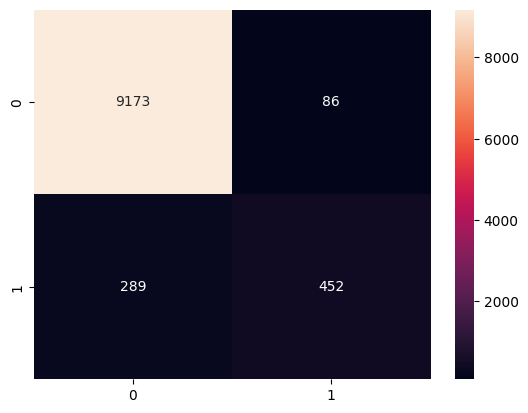

In [18]:
model = RandomForestClassifier(n_estimators = 200, max_depth = 25, min_samples_leaf = 5)
all_y_pred = run_and_eval(model_class=model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test, y_test=y_test)

### XGBOOST

Accuracy: 0.9609
Precision: 0.7708978328173375
Recall: 0.6720647773279352
F1 Score: 0.7180966113914924
AUC-ROC: 0.8280401648817017
Mean Absolute Error: 0.0391
Root Mean Squared Error: 0.1977371993328519


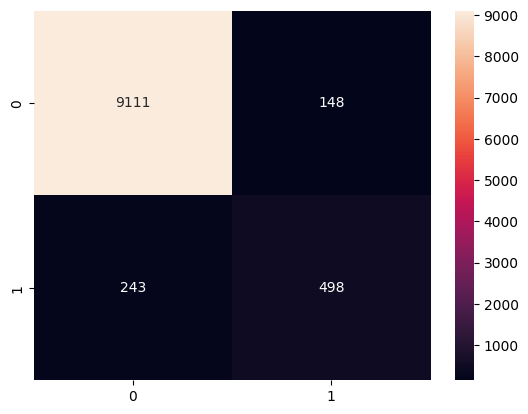

In [19]:
model = XGBClassifier(n_estimators=200, max_depth=50, eta=0.05, gamma=0.1, reg_lambda=0.8, min_child_weight=2)
all_y_pred = run_and_eval(model_class=model,
             X_train=X_train,
             y_train=y_train,
             X_test=X_test, y_test=y_test)

## Deep models - Fully connected neural network

In [20]:
class nn_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(nn_model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.fc4 = nn.Linear(hidden_dim*2, output_dim)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x, labels=None):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        if labels is None:
            return out, None
        loss = self.loss(out, labels)
        return out, loss

In [27]:
def tokenize_data(df, if_train):
    dataset = []
    labels = []
    for index, row in df.iterrows():
        patient_label = row['SepsisLabel']
        patient_label = np.array([patient_label])
        np_vec = np.array([row.drop(['SepsisLabel','patient id']).values.tolist()])
        tensor_data_matrix = torch.tensor(np_vec, dtype=torch.float32)
        tensor_labels = torch.LongTensor(patient_label)
        dataset.append(tensor_data_matrix)
        labels.append(tensor_labels)
        
    return dataset, labels

In [28]:
train_dataset, train_labels = tokenize_data(train_df, True)
test_dataset, test_labels = tokenize_data(test_df, False)
data_sets = {"train": train_dataset, "test": test_dataset}
labels_sets = {"train": train_labels, "test": test_labels}

In [37]:
def learn_and_predict(data_sets, labels_sets, model, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_F1, dev_F1 = [], []
    model.to(device)
    max_f1 = 0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1} of {num_epochs}")
        print("-" * 30)
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            labels, preds = [], []
            dataset = data_sets[phase]
            all_labels = labels_sets[phase]
            epoch_loss = 0
            counter = 0
            for patient, curr_labels in zip(dataset, all_labels):
                if phase == "train":
                    optimizer.zero_grad()
                    outputs, loss = model(patient, curr_labels)
                    epoch_loss += loss
                    counter += 1
                    loss.backward()
                    optimizer.step()
                else:
                    outputs, loss = model(patient, curr_labels)
                    epoch_loss += loss
                    counter += 1
                    
                pred = [outputs.argmax(dim=1).clone().detach().item()]
                labels += curr_labels.cpu().view(-1).tolist()
                preds += pred
                
            print(f"{phase} metric \n")
            evaluate_model(labels, preds)
            print()
        print()

In [31]:
def run():
    model = nn_model(29, 58, 2)
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True)
    learn_and_predict(data_sets, labels_sets, model, optimizer, 2)

Epoch 1 of 2
------------------------------
train metric 

Accuracy: 0.8772673733804476
Precision: 0.7437908496732026
Recall: 0.4021201413427562
F1 Score: 0.5220183486238532
AUC-ROC: 0.687208480565371
Mean Absolute Error: 0.12273262661955242
Root Mean Squared Error: 0.35033216612174284


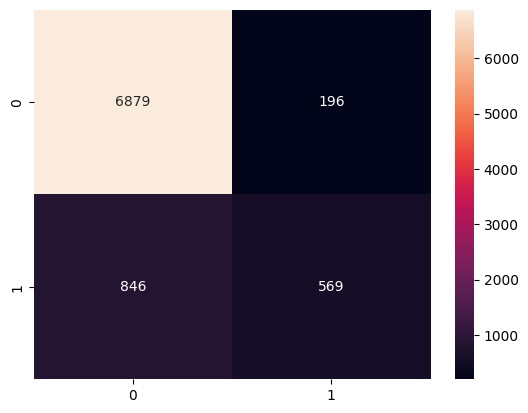


test metric 

Accuracy: 0.9419
Precision: 0.6047120418848168
Recall: 0.6234817813765182
F1 Score: 0.613953488372093
AUC-ROC: 0.7954324340514732
Mean Absolute Error: 0.0581
Root Mean Squared Error: 0.241039415863879


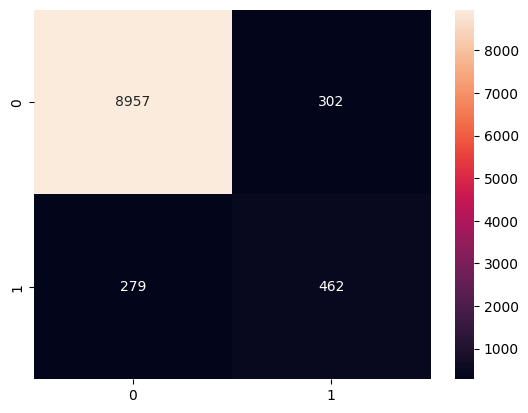



Epoch 2 of 2
------------------------------
train metric 

Accuracy: 0.9088339222614841
Precision: 0.8370136698212408
Recall: 0.5625441696113074
F1 Score: 0.672865595942519
AUC-ROC: 0.7703180212014133
Mean Absolute Error: 0.0911660777385159
Root Mean Squared Error: 0.3019372082710508


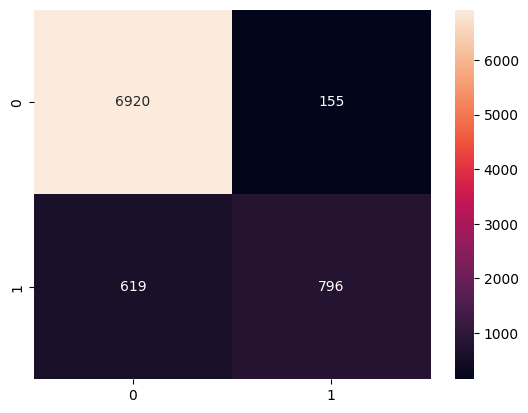


test metric 

Accuracy: 0.936
Precision: 0.5585168018539977
Recall: 0.650472334682861
F1 Score: 0.6009975062344141
AUC-ROC: 0.8046615912533001
Mean Absolute Error: 0.064
Root Mean Squared Error: 0.25298221281347033


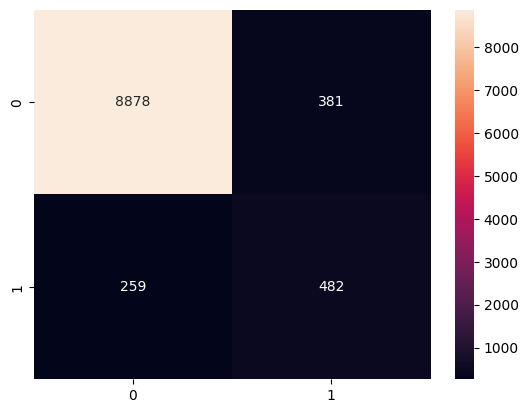

In [38]:
run()